In [1]:
# ===================== CELDA 0: CONFIG GLOBAL =====================
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import joblib

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr

warnings.filterwarnings("ignore", category=FutureWarning)

# ---- PATH DEL EXPERIMENTO A ANALIZAR ----
RESULTS_DIR = Path("/home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_ld256_beta66_cosinewarm")
N_FOLDS = 5
TARGET_CLF = "mlp"  # cambia a "logreg", "svm", etc. si querés

print(f"[INFO] Analizando experimento en:\n{RESULTS_DIR.resolve()}")

# ---- ESTILO FIGURAS “Q1” ----
plt.style.use("default")
sns.set_style("white")

mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"],
    "font.size": 10,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "figure.dpi": 300,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

# Carpeta para figuras/tablas de este experimento
OUTPUT_FIG_DIR = RESULTS_DIR / "training_qc"
OUTPUT_FIG_DIR.mkdir(exist_ok=True)
print(f"[INFO] Figuras/tablas se guardarán en: {OUTPUT_FIG_DIR}")


[INFO] Analizando experimento en:
/home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_ld256_beta66_cosinewarm
[INFO] Figuras/tablas se guardarán en: /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_ld256_beta66_cosinewarm/training_qc


In [2]:
# ===================== CELDA 1: CARGA DE ARTEFACTOS =====================
# 1) Métricas agregadas por fold
metrics_path = next(RESULTS_DIR.glob("all_folds_metrics_MULTI_*.csv"))
metrics_df = pd.read_csv(metrics_path)
print(f"[OK] Métricas CV cargadas desde:\n{metrics_path.name}")

# 2) Historias de entrenamiento del VAE
try:
    vae_hist_path = next(RESULTS_DIR.glob("all_folds_vae_training_history_*.joblib"))
    vae_histories = joblib.load(vae_hist_path)
    print(f"[OK] Historias VAE cargadas ({len(vae_histories)} folds) desde:\n{vae_hist_path.name}")
except StopIteration:
    vae_histories = None
    print("[WARN] No se encontró all_folds_vae_training_history_*.joblib")

# 3) QC latente y fuga de sitio (outputs de analysis_qc.py + latent_qc_metrics.py)
qc_latent_list = []
leak_train_list = []
dist_raw_list, dist_norm_list, dist_recon_list = [], [], []

for k in range(1, N_FOLDS + 1):
    fold_dir = RESULTS_DIR / f"fold_{k}"

    # --- QC latente por fold ---
    qc_path = fold_dir / "latent_qc_metrics.csv"
    if qc_path.exists():
        df_qc = pd.read_csv(qc_path)
        if "fold" not in df_qc.columns:
            df_qc["fold"] = k
        qc_latent_list.append(df_qc)
    else:
        print(f"[WARN] No se encontró {qc_path.name} en fold_{k}")

    # --- Fuga de sitio (LogReg multi-clase) ---
    leak_path = fold_dir / f"fold_{k}_scanner_leakage.csv"
    if leak_path.exists():
        df_leak = pd.read_csv(leak_path)
        df_leak["fold"] = k
        leak_train_list.append(df_leak)
    else:
        print(f"[WARN] No se encontró {leak_path.name}")

    # --- Stats de distribuciones (raw / norm / recon) ---
    for stage, store in [("raw", dist_raw_list),
                         ("norm", dist_norm_list),
                         ("recon", dist_recon_list)]:
        dist_path = fold_dir / f"fold_{k}_dist_{stage}.csv"
        if dist_path.exists():
            df_dist = pd.read_csv(dist_path)
            df_dist["fold"] = k
            store.append(df_dist)

qc_latent = pd.concat(qc_latent_list, ignore_index=True) if qc_latent_list else None
leak_train = pd.concat(leak_train_list, ignore_index=True) if leak_train_list else None
dist_raw_all = pd.concat(dist_raw_list, ignore_index=True) if dist_raw_list else None
dist_norm_all = pd.concat(dist_norm_list, ignore_index=True) if dist_norm_list else None
dist_recon_all = pd.concat(dist_recon_list, ignore_index=True) if dist_recon_list else None

print("\n[RESUMEN]")
print("  QC latente:", None if qc_latent is None else qc_latent.shape)
print("  Leakage train:", None if leak_train is None else leak_train.shape)
print("  Dist raw:", None if dist_raw_all is None else dist_raw_all.shape)
print("  Dist norm:", None if dist_norm_all is None else dist_norm_all.shape)
print("  Dist recon:", None if dist_recon_all is None else dist_recon_all.shape)


[OK] Métricas CV cargadas desde:
all_folds_metrics_MULTI_xgb_vaeconvtranspose4l_ld256_beta6.6_normzscore_offdiag_ch3sel_intFCquarter_drop0.2_ln0_outer5x1_scoreroc_auc.csv
[OK] Historias VAE cargadas (5 folds) desde:
all_folds_vae_training_history_xgb_vaeconvtranspose4l_ld256_beta6.6_normzscore_offdiag_ch3sel_intFCquarter_drop0.2_ln0_outer5x1_scoreroc_auc.joblib

[RESUMEN]
  QC latente: (5, 12)
  Leakage train: (10, 7)
  Dist raw: (15, 17)
  Dist norm: (15, 17)
  Dist recon: (15, 18)


In [3]:
# ===================== CELDA 2: TABLA MAESTRA POR FOLD =====================
# nos quedamos con el clasificador objetivo
m_clf = metrics_df[metrics_df["actual_classifier_type"] == TARGET_CLF].copy()
if m_clf.empty:
    raise ValueError(f"No hay filas para actual_classifier_type == '{TARGET_CLF}'")

# --- pivot de leakage (LogReg sitio) ---
if leak_train is not None:
    leak_pivot = (
        leak_train
        .pivot_table(index="fold",
                     columns="representation",
                     values="balanced_accuracy_mean")
        .rename(columns={
            "connectome_norm": "BA_site_connectome_norm",
            "latent_mu": "BA_site_latent_mu"
        })
        .reset_index()
    )
    # chance: 1 / n_clases por fold
    chance_site = (
        leak_train.groupby("fold")["n_classes"]
        .first()
        .rdiv(1.0)
        .reset_index()
        .rename(columns={"n_classes": "BA_site_chance"})
    )
    leak_summary = leak_pivot.merge(chance_site, on="fold", how="left")
else:
    leak_summary = pd.DataFrame()

# --- merge métricas + QC latente + leakage ---
df_summary = m_clf.merge(qc_latent, on="fold", how="left", suffixes=("","_latentqc"))
if not leak_summary.empty:
    df_summary = df_summary.merge(leak_summary, on="fold", how="left")

# métricas derivadas
if "acc_site_latent" in df_summary.columns and "chance_level" in df_summary.columns:
    df_summary["Delta_site_latent_knn"] = df_summary["acc_site_latent"] - df_summary["chance_level"]
    df_summary["Delta_site_raw_knn"]    = df_summary["acc_site_raw"] - df_summary["chance_level"]

if "BA_site_latent_mu" in df_summary.columns and "BA_site_chance" in df_summary.columns:
    df_summary["Delta_site_latent_logreg"] = df_summary["BA_site_latent_mu"] - df_summary["BA_site_chance"]
    df_summary["Delta_site_conn_logreg"]   = df_summary["BA_site_connectome_norm"] - df_summary["BA_site_chance"]

cols_show = [
    "fold", "auc", "balanced_accuracy",
    "silhouette_latent",
    "acc_site_latent", "acc_site_raw", "chance_level",
    "BA_site_connectome_norm", "BA_site_latent_mu", "BA_site_chance",
    "Delta_site_latent_knn", "Delta_site_latent_logreg"
]
cols_show = [c for c in cols_show if c in df_summary.columns]

display(df_summary[cols_show].round(4))

# guardamos para el paper
csv_path = OUTPUT_FIG_DIR / "table_training_qc_summary.csv"
tex_path = OUTPUT_FIG_DIR / "table_training_qc_summary.tex"

df_summary_round = df_summary.copy()
for c in df_summary_round.columns:
    if df_summary_round[c].dtype.kind in "fc":
        df_summary_round[c] = df_summary_round[c].round(3)

df_summary_round.to_csv(csv_path, index=False)
with open(tex_path, "w") as f:
    f.write(df_summary_round[cols_show].to_latex(index=False, escape=False, column_format="ccccccccccc"))

print(f"[OK] Tabla maestra guardada en:\n  {csv_path}\n  {tex_path}")


,fold,auc,balanced_accuracy,silhouette_latent,acc_site_latent,acc_site_raw,chance_level,BA_site_connectome_norm,BA_site_latent_mu,BA_site_chance,Delta_site_latent_knn,Delta_site_latent_logreg
0,1,0.8977,0.7865,0.0177,0.4210,0.3543,0.3333,0.7040,0.7126,0.3333,0.0877,0.3793
1,2,0.7807,0.7047,0.0080,0.3333,0.3333,0.3333,0.6441,0.6038,0.3333,0.0000,0.2705
2,3,0.8304,0.7558,0.0158,0.4861,0.4603,0.3333,0.7646,0.7631,0.3333,0.1528,0.4298
3,4,0.8012,0.7295,0.0172,0.5067,0.5733,0.3333,0.5889,0.6486,0.3333,0.1733,0.3153
4,5,0.6502,0.6161,0.0071,0.5833,0.6250,0.3333,0.6579,0.6238,0.3333,0.2500,0.2905


[OK] Tabla maestra guardada en:
  /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_ld256_beta66_cosinewarm/training_qc/table_training_qc_summary.csv
  /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_ld256_beta66_cosinewarm/training_qc/table_training_qc_summary.tex


In [4]:
# === Resumen global (media ± SD) para el paper ===
cols_to_agg = [
    "auc",
    "balanced_accuracy",
    "silhouette_latent",
    "Delta_site_latent_knn",
    "Delta_site_latent_logreg"
]
cols_to_agg = [c for c in cols_to_agg if c in df_summary.columns]

summary_stats = df_summary[cols_to_agg].agg(["mean", "std"]).T
summary_stats = summary_stats.rename(columns={"mean": "mean", "std": "sd"})
display(summary_stats.round(3))

# opcional: export a LaTeX
with open(OUTPUT_FIG_DIR / "table_training_qc_summary_global.tex", "w") as f:
    f.write(summary_stats.round(3).to_latex(escape=False, column_format="lcc"))


,mean,sd
auc,0.792,0.091
balanced_accuracy,0.719,0.065
silhouette_latent,0.013,0.005
Delta_site_latent_knn,0.133,0.094
Delta_site_latent_logreg,0.337,0.066



--- Correlaciones (Spearman) ---
Spearman(Silhouette, AUC) = 0.900, p = 0.037
Spearman(Site BA (latent, LogReg), AUC) = 0.800, p = 0.104
Spearman(Site acc (latent, kNN), AUC) = -0.400, p = 0.505


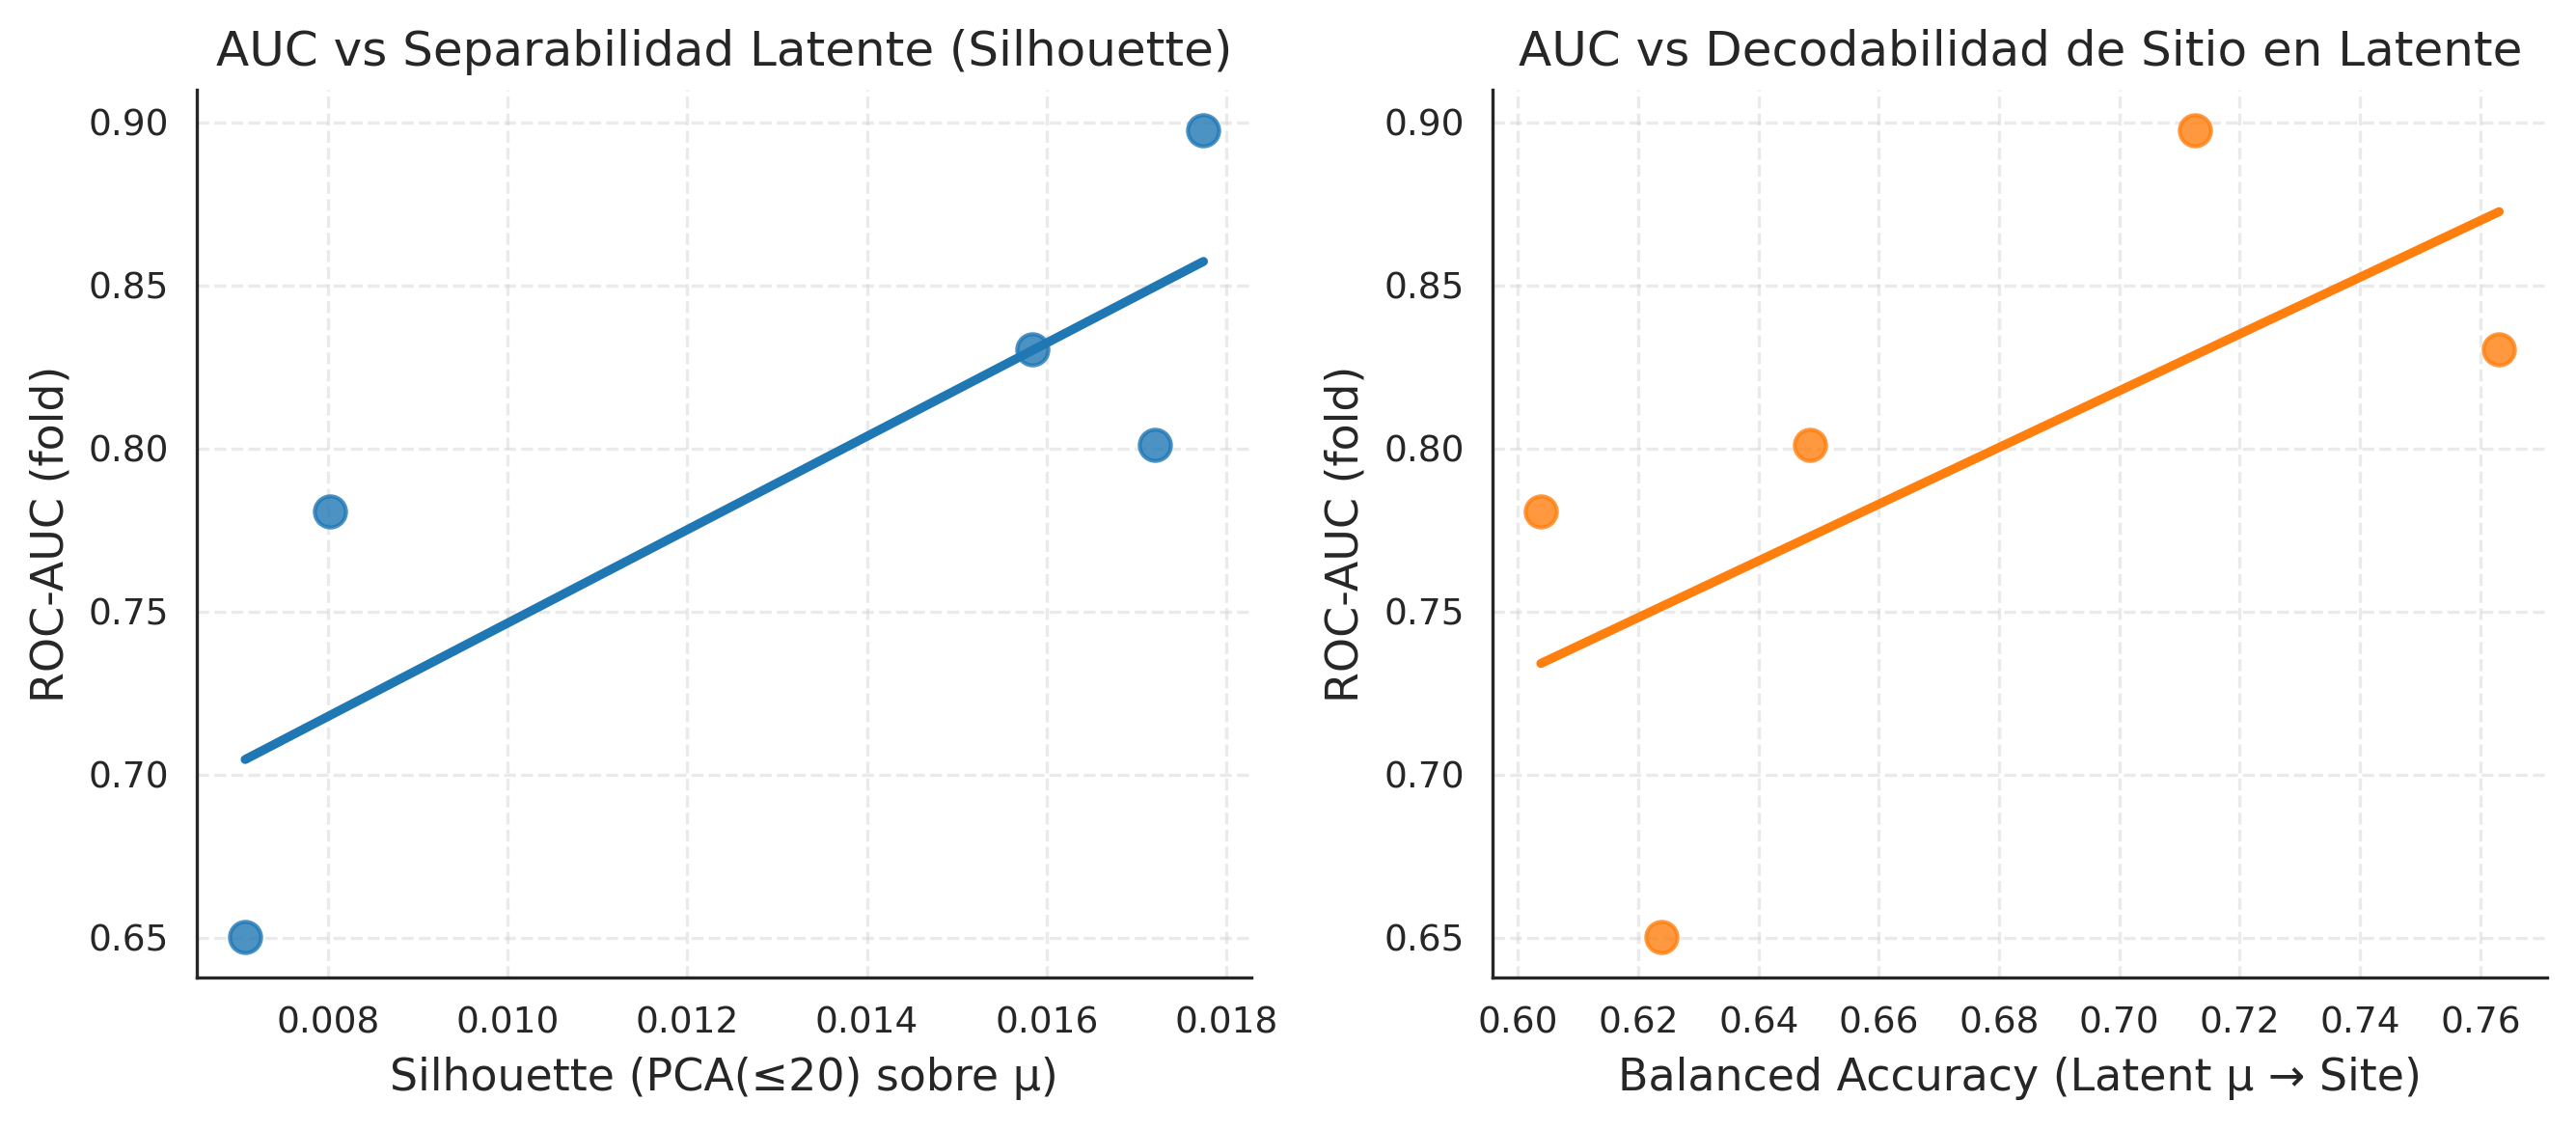

[OK] Figura AUC vs QC latente guardada.


In [5]:
# ===================== CELDA 3: CORRELACIONES AUC vs QC =====================
df_plot = df_summary.dropna(subset=["auc", "silhouette_latent"]).copy()

# correlaciones de Spearman (N=5 → interpretarlas con cautela)
def corr_and_print(x, y, label_x, label_y):
    r, p = spearmanr(x, y)
    print(f"Spearman({label_x}, {label_y}) = {r:.3f}, p = {p:.3f}")
    return r, p

print("\n--- Correlaciones (Spearman) ---")
corr_and_print(df_plot["silhouette_latent"], df_plot["auc"],
               "Silhouette", "AUC")

if "BA_site_latent_mu" in df_plot.columns:
    corr_and_print(df_plot["BA_site_latent_mu"], df_plot["auc"],
                   "Site BA (latent, LogReg)", "AUC")

if "acc_site_latent" in df_plot.columns:
    corr_and_print(df_plot["acc_site_latent"], df_plot["auc"],
                   "Site acc (latent, kNN)", "AUC")

# --- Figura: AUC vs Silhouette y AUC vs fuga de sitio latente ---
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

# A) AUC vs Silhouette
sns.regplot(data=df_plot, x="silhouette_latent", y="auc",
            ax=axes[0], ci=None, scatter_kws={"s":60})
axes[0].set_title("AUC vs Separabilidad Latente (Silhouette)")
axes[0].set_xlabel("Silhouette (PCA(≤20) sobre μ)")
axes[0].set_ylabel("ROC-AUC (fold)")
axes[0].grid(True, linestyle="--", alpha=0.4)

# B) AUC vs fuga de sitio en latente (LogReg)
if "BA_site_latent_mu" in df_plot.columns:
    sns.regplot(data=df_plot, x="BA_site_latent_mu", y="auc",
                ax=axes[1], ci=None, scatter_kws={"s":60}, color="tab:orange")
    axes[1].set_title("AUC vs Decodabilidad de Sitio en Latente")
    axes[1].set_xlabel("Balanced Accuracy (Latent μ → Site)")
    axes[1].set_ylabel("ROC-AUC (fold)")
    axes[1].grid(True, linestyle="--", alpha=0.4)
else:
    axes[1].axis("off")

fig.tight_layout()
fig.savefig(OUTPUT_FIG_DIR / "figure_auc_vs_qc_latent.pdf", bbox_inches="tight")
fig.savefig(OUTPUT_FIG_DIR / "figure_auc_vs_qc_latent.png", dpi=300, bbox_inches="tight")

plt.show()
print("[OK] Figura AUC vs QC latente guardada.")


Ploteando dinámica VAE para folds: best=1, worst=5


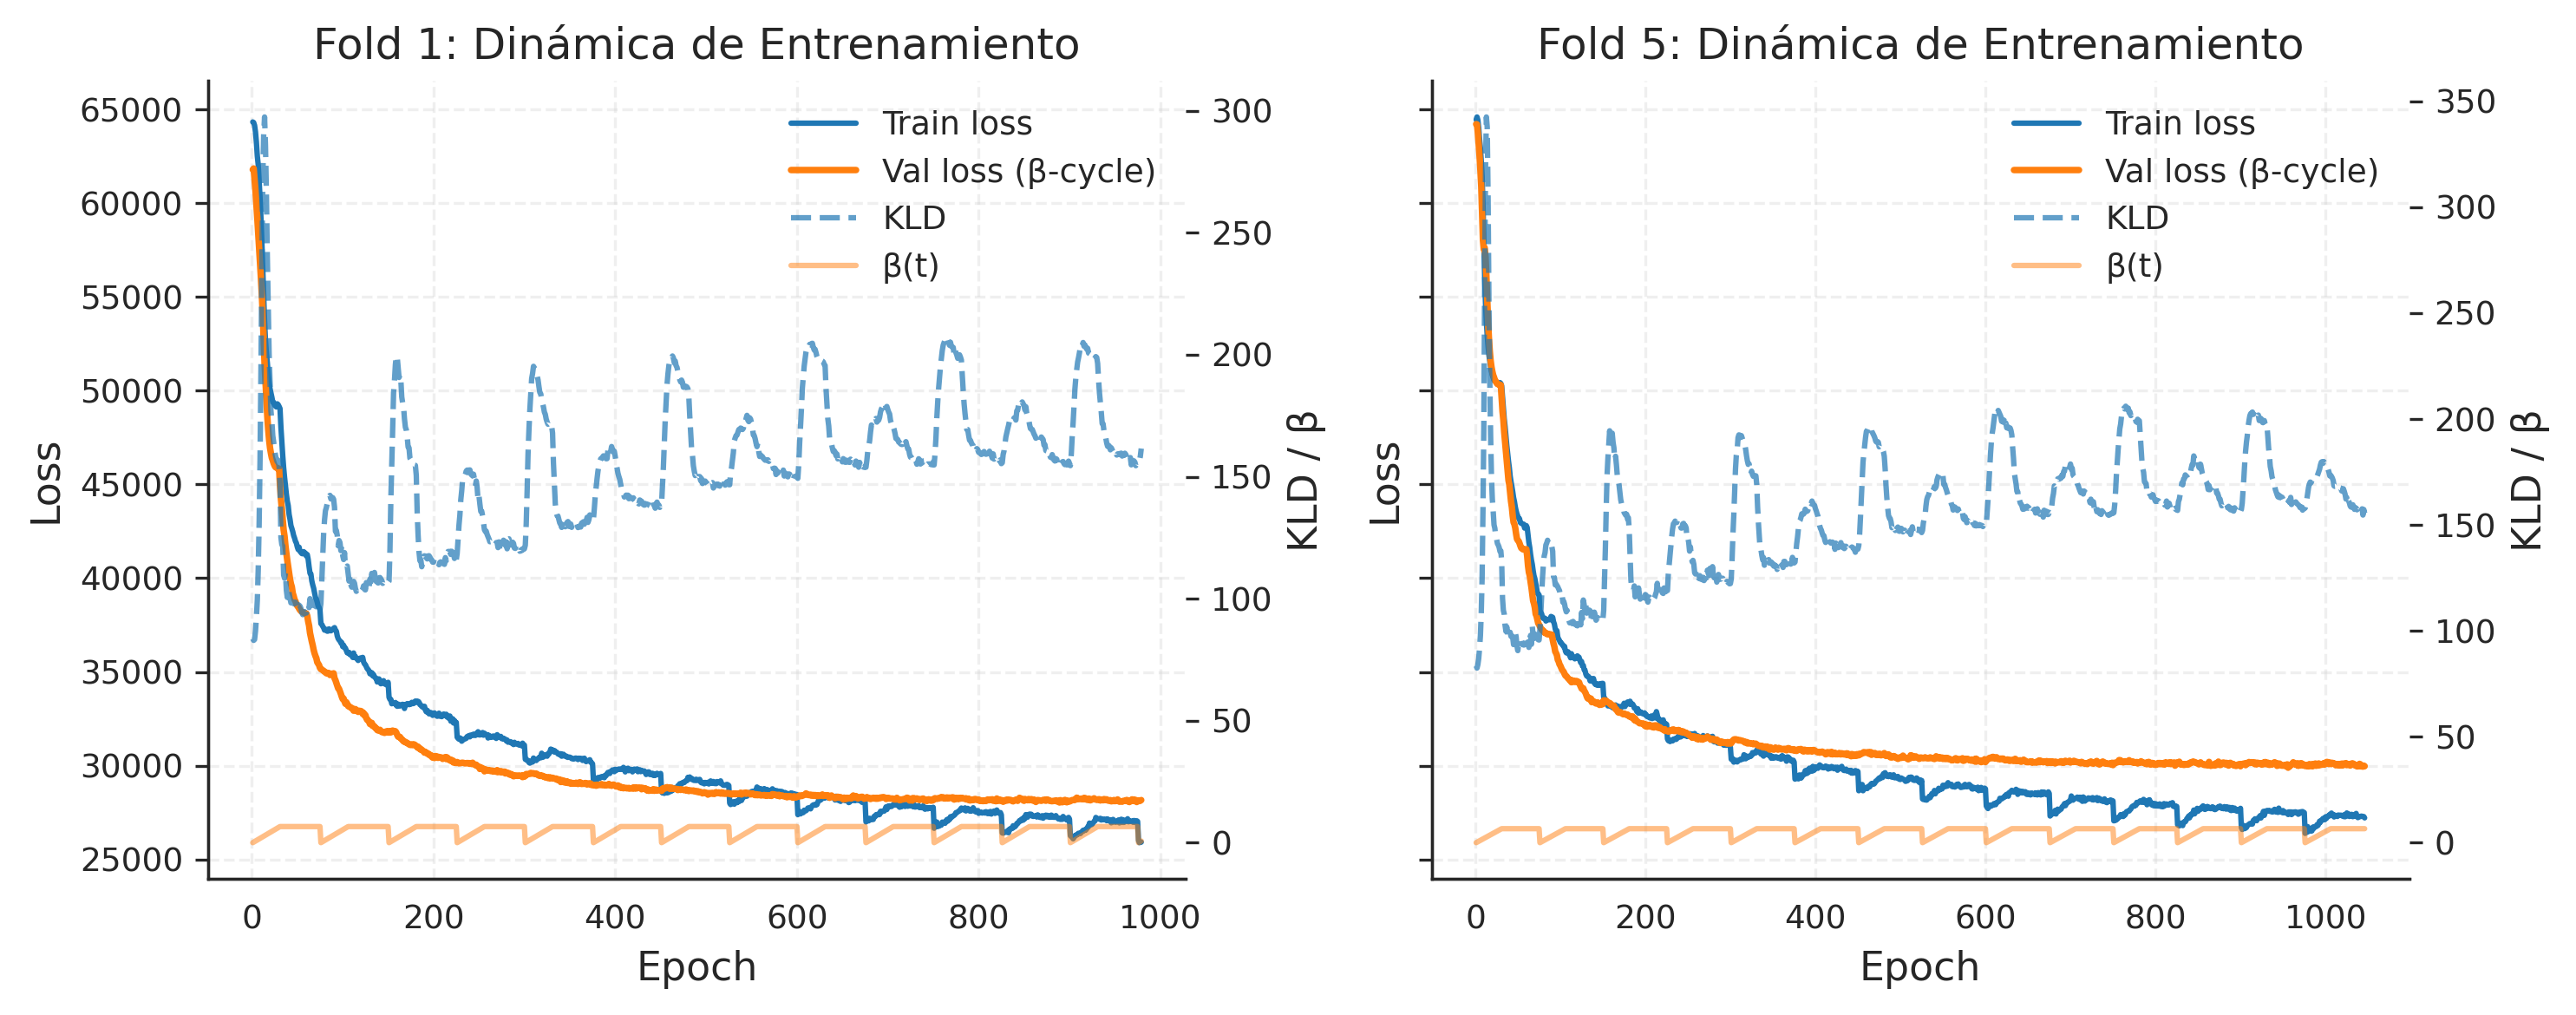

[OK] Dinámica VAE guardada.


In [6]:
# ===================== CELDA 4: DINÁMICA DE ENTRENAMIENTO VAE =====================
if vae_histories is None:
    print("[WARN] No se cargaron historias de entrenamiento del VAE.")
else:
    # identificamos fold con mejor y peor AUC
    best_fold = int(df_summary.loc[df_summary["auc"].idxmax(), "fold"])
    worst_fold = int(df_summary.loc[df_summary["auc"].idxmin(), "fold"])
    folds_to_plot = [best_fold, worst_fold]

    print(f"Ploteando dinámica VAE para folds: best={best_fold}, worst={worst_fold}")

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    for ax, fold_k in zip(axes, folds_to_plot):
        history = vae_histories[fold_k - 1]  # lista, índice 0 → Fold 1

        epochs = np.arange(1, len(history["train_loss"]) + 1)
        ax.plot(epochs, history["train_loss"], label="Train loss", lw=1.5)
        ax.plot(epochs, history["val_loss_modelsel"], label="Val loss (β-cycle)", lw=1.8)

        ax2 = ax.twinx()
        ax2.plot(epochs, history["train_kld"], linestyle="--", alpha=0.7, label="KLD")
        ax2.plot(epochs, history["beta"], alpha=0.5, label="β(t)")

        ax.set_title(f"Fold {fold_k}: Dinámica de Entrenamiento")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.grid(True, linestyle="--", alpha=0.3)
        ax2.set_ylabel("KLD / β")

        # leyenda combinada
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2, loc="upper right", frameon=False)

    fig.tight_layout()
    fig.savefig(OUTPUT_FIG_DIR / "figure_vae_training_dynamics_best_vs_worst.pdf", bbox_inches="tight")
    fig.savefig(OUTPUT_FIG_DIR / "figure_vae_training_dynamics_best_vs_worst.png", dpi=300, bbox_inches="tight")
    plt.show()
    print("[OK] Dinámica VAE guardada.")



--- Fuga de sitio por fold (Balanced Accuracy) ---


representation,connectome_norm,latent_mu
fold_tag,,
fold_1,0.704,0.713
fold_2,0.644,0.604
fold_3,0.765,0.763
fold_4,0.589,0.649
fold_5,0.658,0.624



--- Resumen por representación (mean±sd, median) ---


balanced_accuracy_mean               chance              \
                                  mean    std median   mean  std median   
representation                                                            
connectome_norm                  0.672  0.066  0.658  0.333  0.0  0.333   
latent_mu                        0.670  0.066  0.649  0.333  0.0  0.333   

                DeltaBA                
                   mean    std median  
representation                         
connectome_norm   0.339  0.066  0.325  
latent_mu         0.337  0.066  0.315

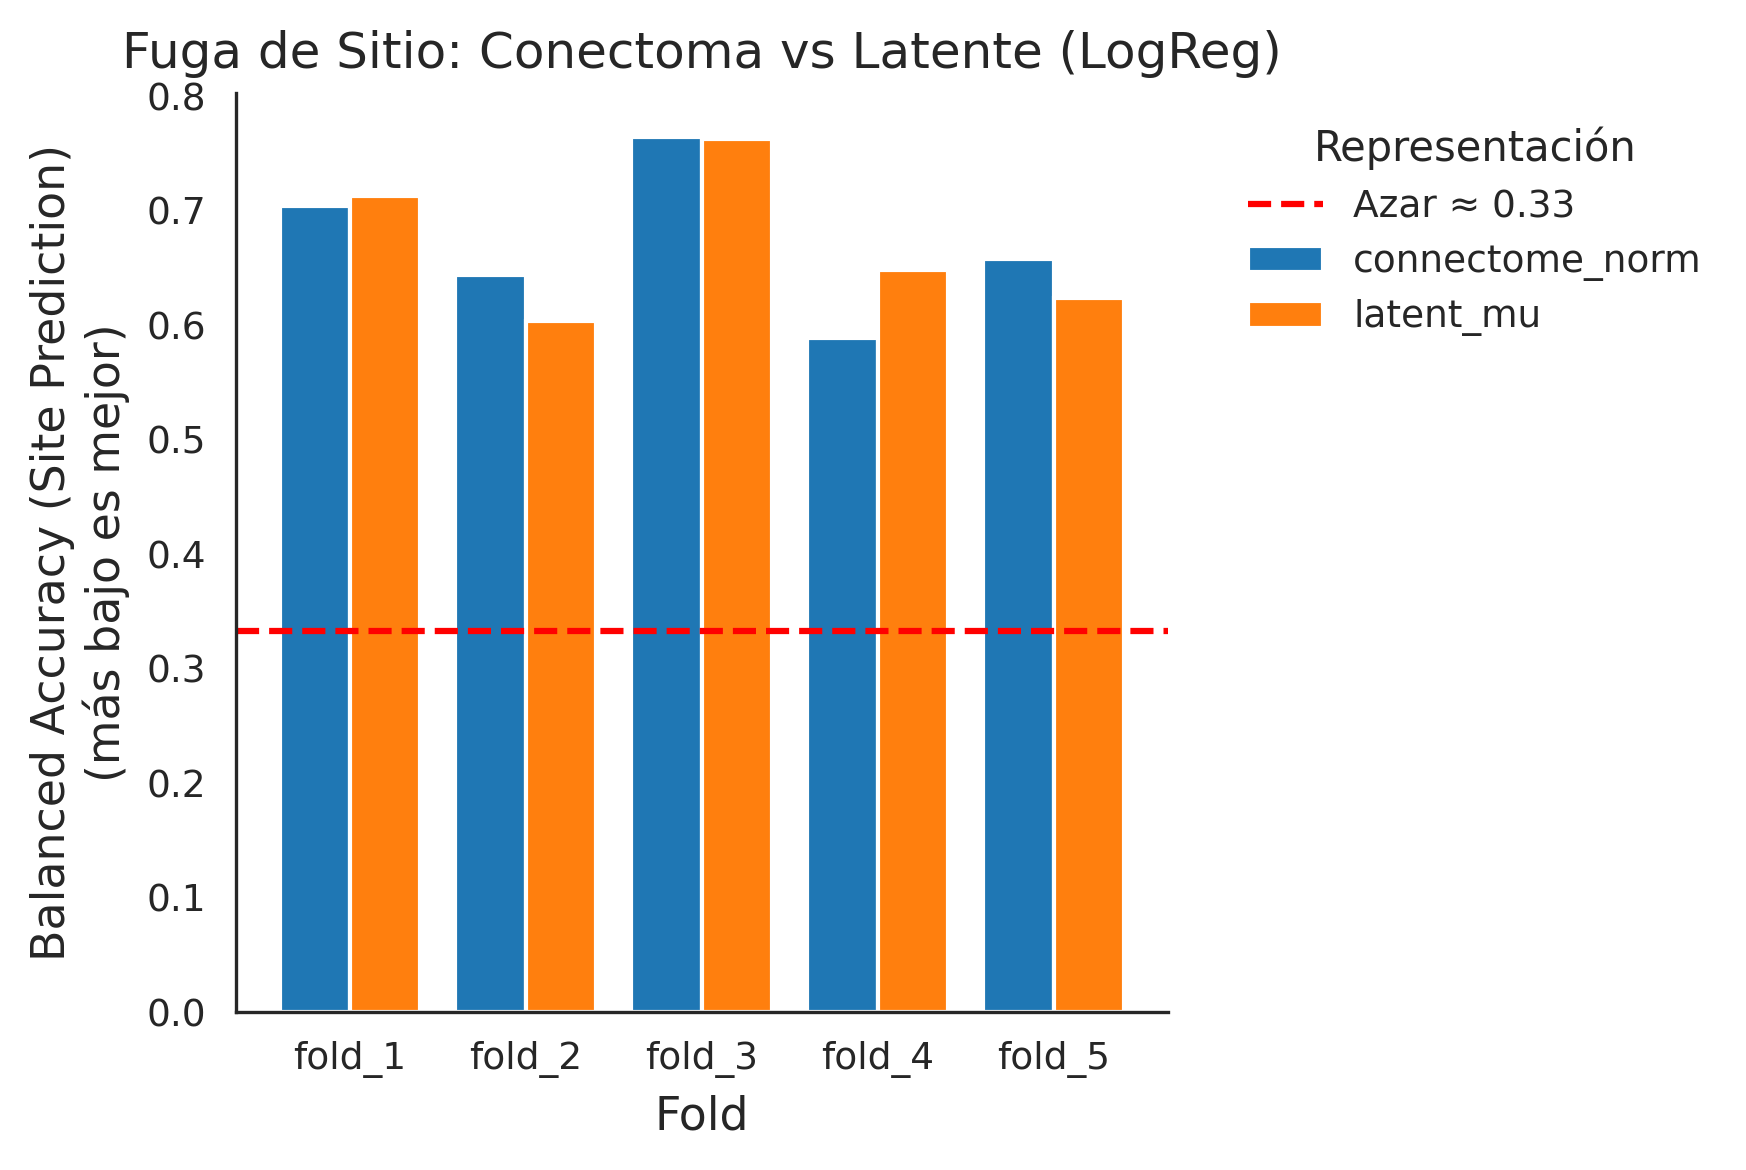

[OK] Tablas de fuga de sitio guardadas.


In [7]:
# ===================== CELDA 5: RESUMEN FUGA DE SITIO (LOGREG) =====================
if leak_train is None:
    print("[WARN] No hay datos de leakage.")
else:
    df_leak_all = leak_train.copy()
    # por si no existe fold_tag
    if "fold_tag" not in df_leak_all.columns:
        df_leak_all["fold_tag"] = df_leak_all["fold"].map(lambda k: f"fold_{k}")

    pivot_leak = df_leak_all.pivot_table(
        index="fold_tag",
        columns="representation",
        values="balanced_accuracy_mean"
    )

    print("\n--- Fuga de sitio por fold (Balanced Accuracy) ---")
    display(pivot_leak.round(3))

    # resumen global (media, std, Delta sobre azar)
    df = df_leak_all.copy()
    df["chance"] = 1.0 / df["n_classes"]
    df["DeltaBA"] = df["balanced_accuracy_mean"] - df["chance"]
    leak_summary_repr = (
        df.groupby("representation")[["balanced_accuracy_mean", "chance", "DeltaBA"]]
        .agg(["mean", "std", "median"])
        .round(3)
    )
    print("\n--- Resumen por representación (mean±sd, median) ---")
    display(leak_summary_repr)

    # gráfica
    fig, ax = plt.subplots(figsize=(6, 4))
    pivot_leak.plot(kind="bar", ax=ax, width=0.8, rot=0)
    ax.set_ylabel("Balanced Accuracy (Site Prediction)\n(más bajo es mejor)")
    ax.set_xlabel("Fold")
    ax.axhline(df["chance"].mean(), color="red", ls="--",
               label=f"Azar ≈ {df['chance'].mean():.2f}")
    ax.set_title("Fuga de Sitio: Conectoma vs Latente (LogReg)")
    ax.legend(title="Representación", frameon=False, bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    fig.savefig(OUTPUT_FIG_DIR / "figure_scanner_leakage_summary.pdf", bbox_inches="tight")
    fig.savefig(OUTPUT_FIG_DIR / "figure_scanner_leakage_summary.png", dpi=300, bbox_inches="tight")
    plt.show()

    # guardamos tablas
    pivot_leak.to_csv(OUTPUT_FIG_DIR / "table_scanner_leakage_by_fold.csv")
    leak_summary_repr.to_csv(OUTPUT_FIG_DIR / "table_scanner_leakage_summary.csv")
    print("[OK] Tablas de fuga de sitio guardadas.")


[INFO] Visualizando fold 1 en /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_ld256_beta66_cosinewarm/fold_1
[OK] Tensor global cargado. Shape: (431, 3, 131, 131)
[OK] Cargando checkpoint: vae_model_fold_1.pt


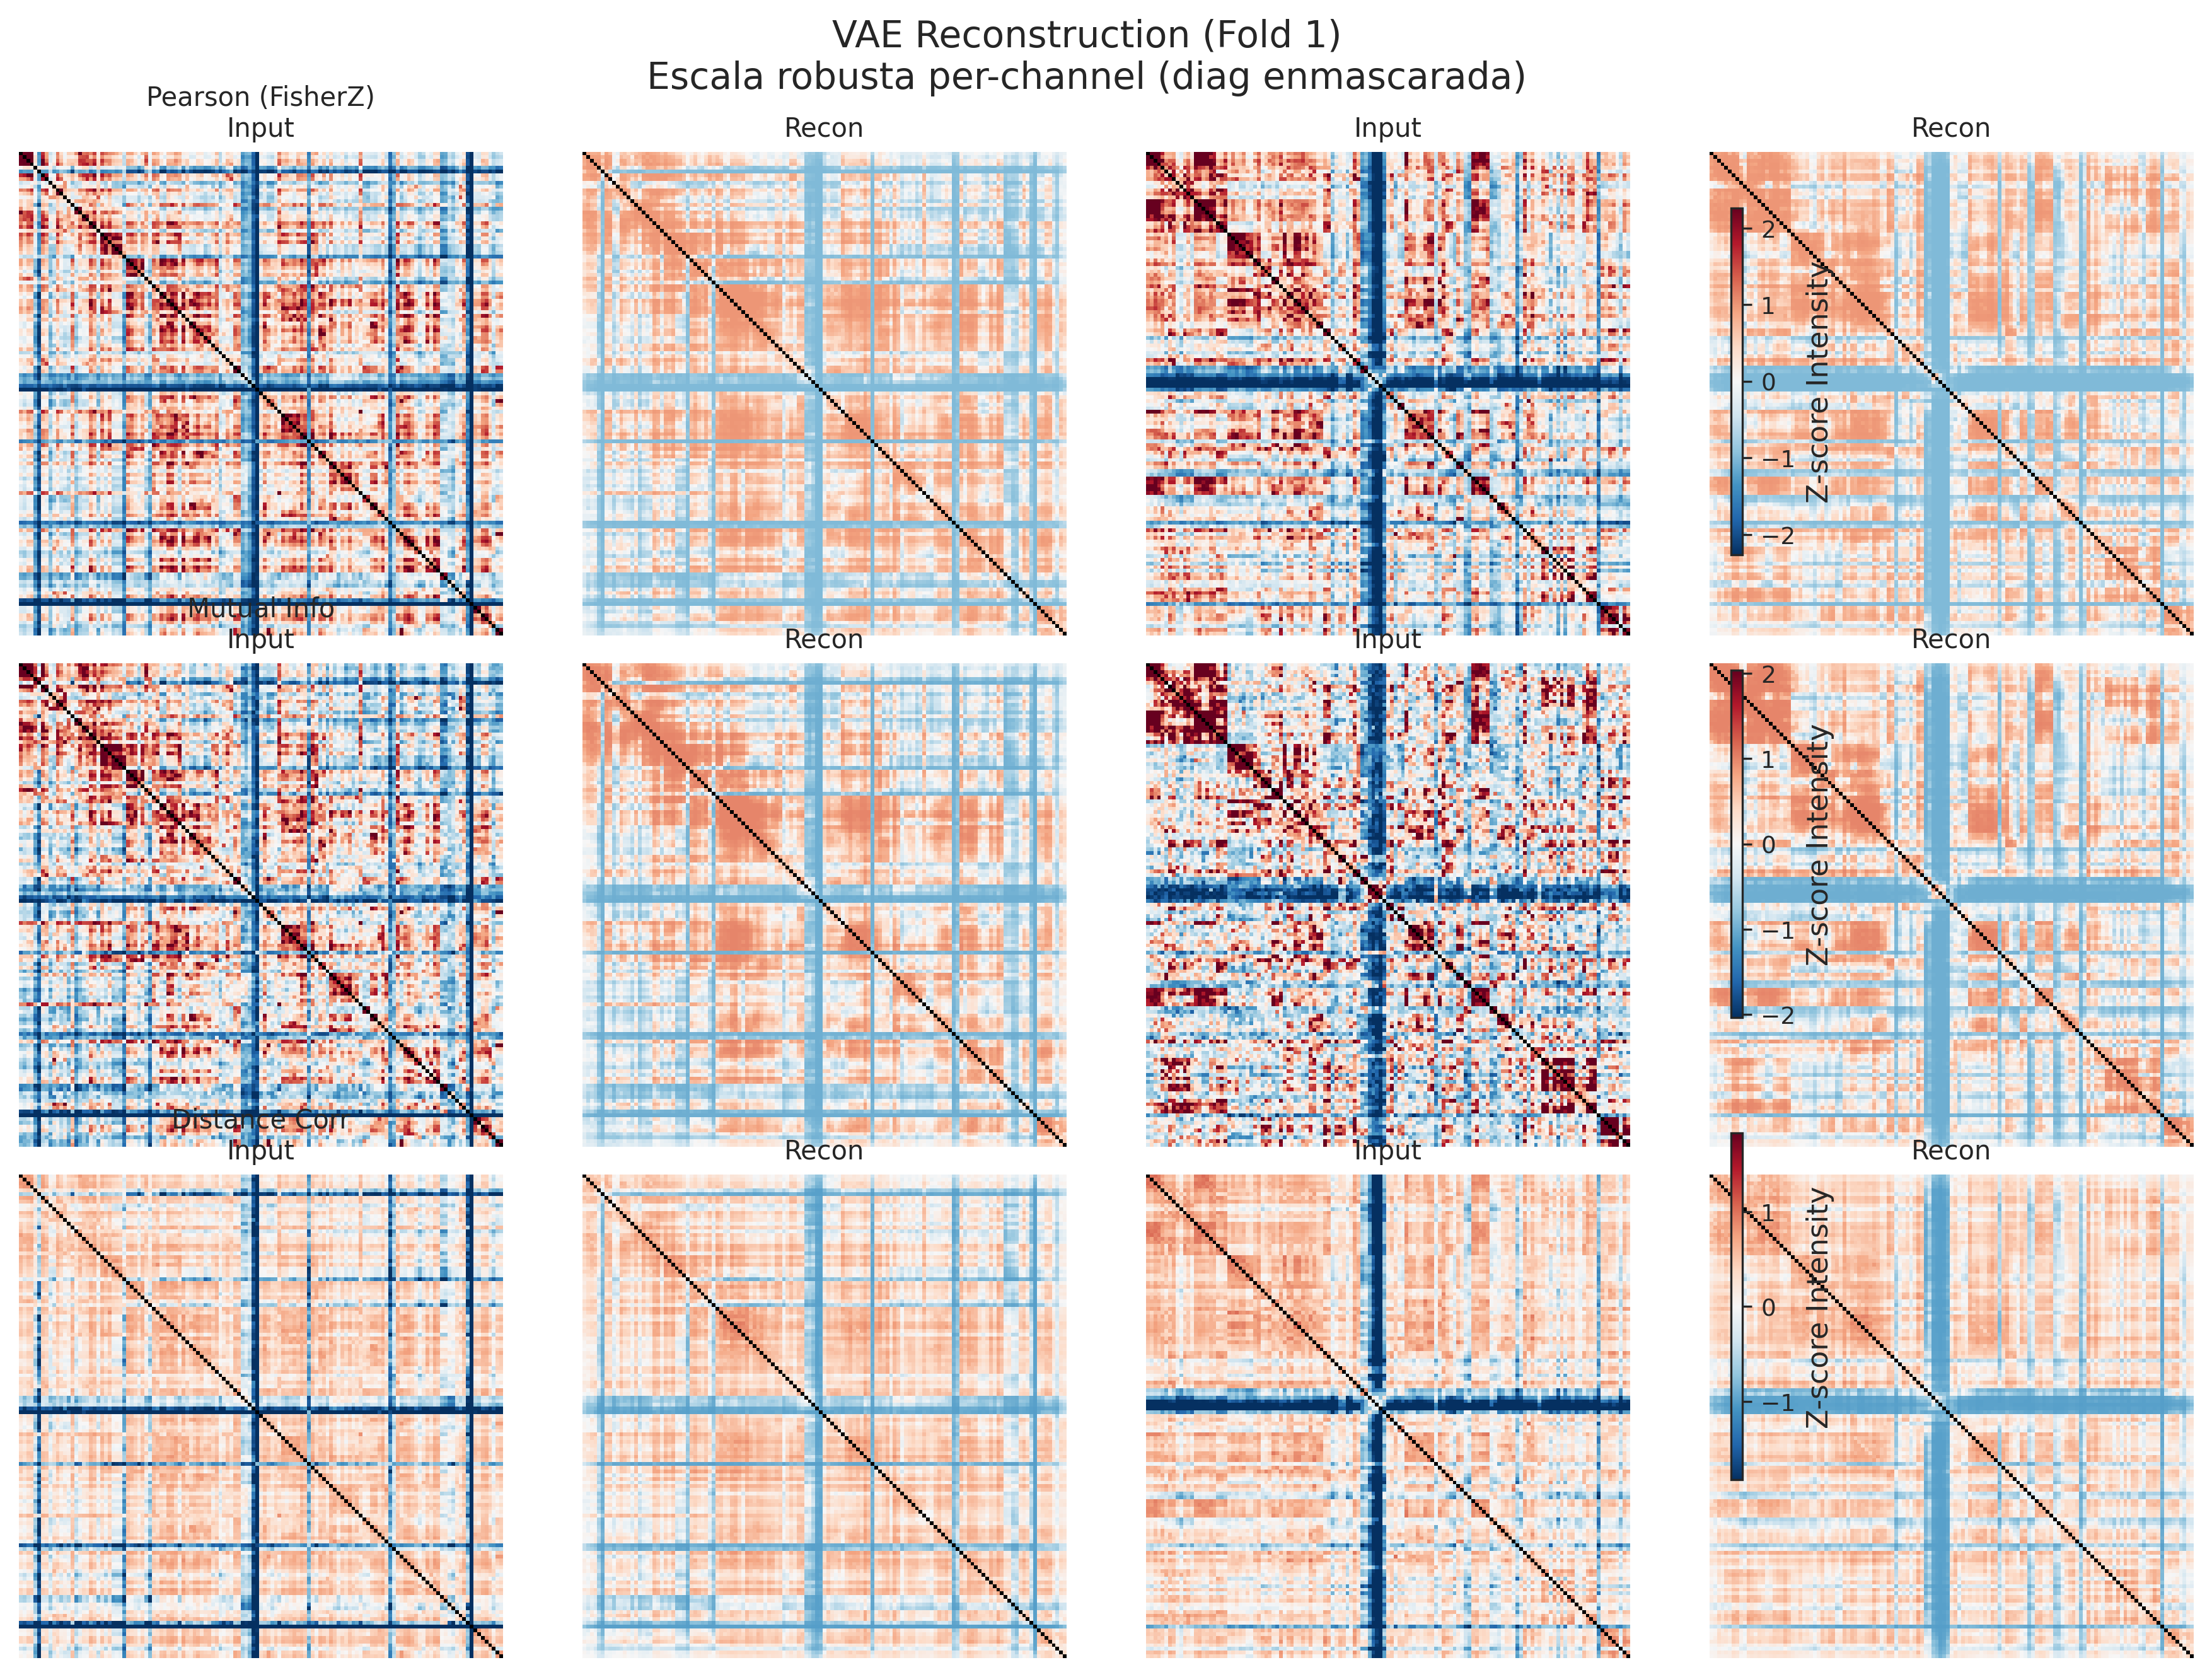

In [8]:
# ===================== CELDA 6 (FINAL): INPUT vs RECONSTRUCCIÓN (ROBUSTA) =====================
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import joblib
from pathlib import Path
import copy

# --- 1. CONFIGURACIÓN ---
project_root = Path.cwd().resolve().parent
src_dir = project_root / "src"
if str(src_dir) not in sys.path:
    sys.path.insert(0, str(src_dir))

try:
    from betavae_xai.models.convolutional_vae import ConvolutionalVAE
except ImportError:
    from src.betavae_xai.models.convolutional_vae import ConvolutionalVAE

# PARÁMETROS (Deben coincidir con tu run_vae_clf_ad.py)
FOLD_TO_VIS = 1
LATENT_DIM = 256
NUM_CONV_LAYERS = 4  
INTERMEDIATE_FC = "quarter" 
DROPOUT = 0.2
LAYERNORM_FC = False 

fold_dir = RESULTS_DIR / f"fold_{FOLD_TO_VIS}"
print(f"[INFO] Visualizando fold {FOLD_TO_VIS} en {fold_dir}")

# --- 2. CARGAR DATOS Y PARÁMETROS ---
norm_params_path = fold_dir / "vae_norm_params.joblib"
if not norm_params_path.exists():
    raise FileNotFoundError(f"Faltan params normalización: {norm_params_path}")
norm_params_list = joblib.load(norm_params_path)

# Cargar Tensor Global
GLOBAL_TENSOR_PATH = project_root / "data/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz"
try:
    data_npz = np.load(GLOBAL_TENSOR_PATH, allow_pickle=True)
    CH_IDXS = [1, 2, 5] # Pearson, MI, DistCorr
    CH_NAMES = ['Pearson (FisherZ)', 'Mutual Info', 'Distance Corr']
    global_t = data_npz['global_tensor_data'][:, CH_IDXS, :, :]
    print(f"[OK] Tensor global cargado. Shape: {global_t.shape}")
except FileNotFoundError:
    raise FileNotFoundError("No se encuentra el .npz global.")

# Selección de sujetos (Arbitrarios del tensor global para Demo)
subj_train_raw = global_t[10]   
subj_test_raw  = global_t[100]  

# --- 3. NORMALIZACIÓN BLINDADA (TU MEJORA) ---
def apply_norm_inference(tensor_mv, params_list):
    C, H, W = tensor_mv.shape
    normed = tensor_mv.copy()
    mask = ~np.eye(H, dtype=bool)
    
    for c in range(C):
        p = params_list[c]
        if not p.get('no_scale', False):
            vals = tensor_mv[c]
            
            if p.get('mode') == 'zscore_offdiag':
                # GUARD: Evitar división por cero
                if p['std'] > 1e-9:
                    normed[c, mask] = (vals[mask] - p['mean']) / p['std']
                else:
                    normed[c, mask] = 0.0
                    
            elif p.get('mode') == 'minmax_offdiag':
                rng = p['max'] - p['min']
                # GUARD: Evitar división por cero
                if rng > 1e-9:
                    normed[c, mask] = (vals[mask] - p['min']) / rng
                else:
                    normed[c, mask] = 0.0
    return normed

subj_train_norm = apply_norm_inference(subj_train_raw, norm_params_list)
subj_test_norm  = apply_norm_inference(subj_test_raw, norm_params_list)

# --- 4. INFERENCIA VAE ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_channels = subj_train_norm.shape[0]
img_size = subj_train_norm.shape[1]

# Instanciación Robusta (con Fallback)
try:
    vae = ConvolutionalVAE(
        input_channels=n_channels,
        latent_dim=LATENT_DIM,
        image_size=img_size,
        num_conv_layers_encoder=NUM_CONV_LAYERS, 
        intermediate_fc_dim_config=INTERMEDIATE_FC, 
        dropout_rate=DROPOUT,
        use_layernorm_fc=LAYERNORM_FC,
        decoder_type="convtranspose",
        final_activation="tanh"
    ).to(device)
    
    ckpt_path = list(fold_dir.glob("vae_model_fold_*.pt"))[0]
    print(f"[OK] Cargando checkpoint: {ckpt_path.name}")
    vae.load_state_dict(torch.load(ckpt_path, map_location=device))
    
except RuntimeError:
    print("\n[WARN] Mismatch de arquitectura detectado. Intentando fallback (FC=0)...")
    vae = ConvolutionalVAE(
        input_channels=n_channels,
        latent_dim=LATENT_DIM,
        image_size=img_size,
        num_conv_layers_encoder=NUM_CONV_LAYERS, 
        intermediate_fc_dim_config=0, 
        dropout_rate=DROPOUT,
        use_layernorm_fc=LAYERNORM_FC,
        decoder_type="convtranspose",
        final_activation="tanh"
    ).to(device)
    vae.load_state_dict(torch.load(ckpt_path, map_location=device))
    print("[OK] Carga exitosa con fallback.")

vae.eval()

# Forward pass
x_tr = torch.from_numpy(subj_train_norm).float().unsqueeze(0).to(device)
x_te = torch.from_numpy(subj_test_norm).float().unsqueeze(0).to(device)

with torch.no_grad():
    recon_tr, _, _, _ = vae(x_tr)
    recon_te, _, _, _ = vae(x_te)

x_tr_np = x_tr.cpu().numpy()[0]
x_te_np = x_te.cpu().numpy()[0]
recon_tr_np = recon_tr.cpu().numpy()[0]
recon_te_np = recon_te.cpu().numpy()[0]

# --- 5. VISUALIZACIÓN ROBUSTA ---
def plot_matrix(ax, mat, title, vmin, vmax):
    mat_masked = mat.copy()
    np.fill_diagonal(mat_masked, np.nan) # Diagonal negra
    cmap = copy.copy(plt.cm.RdBu_r)
    cmap.set_bad(color='black')
    im = ax.imshow(mat_masked, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(title, fontsize=10)
    ax.axis('off')
    return im

fig, axes = plt.subplots(n_channels, 4, figsize=(12, 3 * n_channels))
cols = ["Train Input", "Train Recon", "Test Input", "Test Recon"]
for ax, col in zip(axes[0], cols): ax.set_title(col, fontsize=12, fontweight='bold')

for i in range(n_channels):
    # Escala robusta (percentiles 2-98%)
    flat_vals = np.concatenate([x_tr_np[i].flatten(), recon_tr_np[i].flatten()])
    flat_vals = flat_vals[np.isfinite(flat_vals)]
    vmax = np.percentile(np.abs(flat_vals), 98) 
    vmin = -vmax
    
    plot_matrix(axes[i, 0], x_tr_np[i], f"{CH_NAMES[i]}\nInput", vmin, vmax)
    im = plot_matrix(axes[i, 1], recon_tr_np[i], "Recon", vmin, vmax)
    plot_matrix(axes[i, 2], x_te_np[i], "Input", vmin, vmax)
    plot_matrix(axes[i, 3], recon_te_np[i], "Recon", vmin, vmax)
    
    cbar = plt.colorbar(im, ax=axes[i, :], shrink=0.9, aspect=30, pad=0.02)
    cbar.set_label("Z-score Intensity")

plt.suptitle(f"VAE Reconstruction (Fold {FOLD_TO_VIS})\nEscala robusta per-channel (diag enmascarada)", fontsize=14)
plt.tight_layout()
plt.show()

[OK] Archivo de predicciones encontrado:
all_folds_clf_predictions_MULTI_xgb_vaeconvtranspose4l_ld256_beta6.6_normzscore_offdiag_ch3sel_intFCquarter_drop0.2_ln0_outer5x1_scoreroc_auc.joblib
[OK] Predicciones concatenadas para 'mlp': N=184
[INFO] Prevalencia global AD: 51.6%
Realizando análisis de bootstrap (puede tardar un momento)...
✅ Análisis de bootstrap completado.


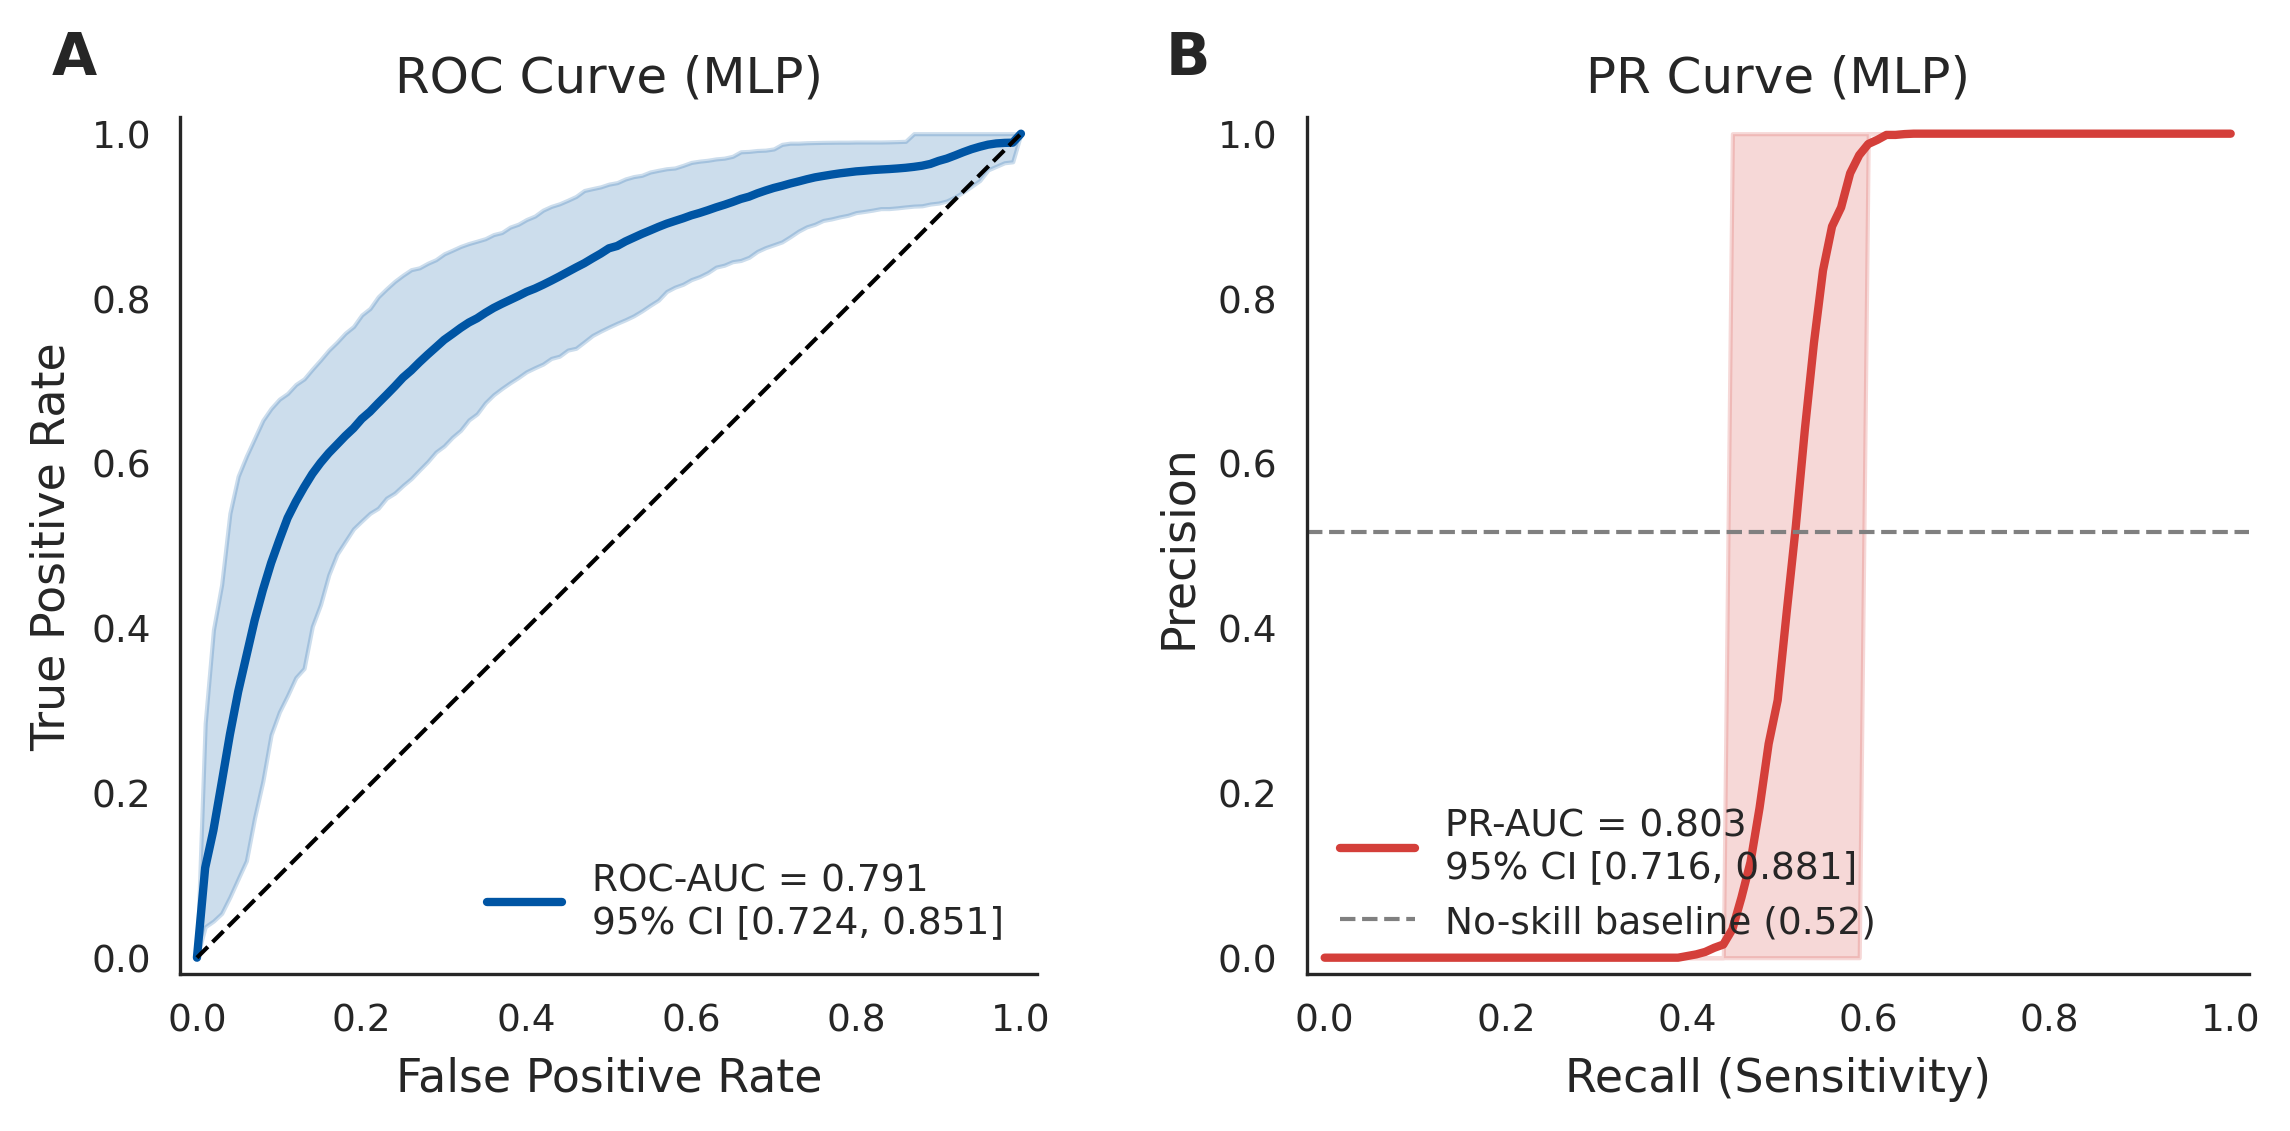


🎉 ¡Figura mejorada guardada en formatos PDF, PNG y SVG en: /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_ld256_beta66_cosinewarm/training_qc/figure_performance_curves_publication_mlp!


In [9]:
# ===================== CELDA 7: CURVAS ROC / PR (POOLED TEST) - ESTILO Q1 =====================
from sklearn.metrics import (
    roc_curve, precision_recall_curve,
    roc_auc_score, average_precision_score
)

# --- 1. CARGA DE DATOS ROBUSTA (Desde .joblib) ---
try:
    # Buscamos el archivo joblib que contiene las predicciones de TODOS los folds
    pred_joblib_path = next(RESULTS_DIR.glob("all_folds_clf_predictions_MULTI_*.joblib"))
    print(f"[OK] Archivo de predicciones encontrado:\n{pred_joblib_path.name}")
    
    # Cargamos la lista de diccionarios
    all_preds_data = joblib.load(pred_joblib_path)
    
    # Filtramos solo las tablas del clasificador que nos interesa (TARGET_CLF)
    relevant_dfs = []
    for item in all_preds_data:
        if item['classifier'] == TARGET_CLF:
            relevant_dfs.append(item['predictions_df'])
            
    if not relevant_dfs:
        raise ValueError(f"No se encontraron predicciones para '{TARGET_CLF}' en el archivo joblib.")
        
    # Concatenamos todos los folds en un solo DataFrame (Pooled Test Set)
    preds_df = pd.concat(relevant_dfs, ignore_index=True)
    print(f"[OK] Predicciones concatenadas para '{TARGET_CLF}': N={len(preds_df)}")

except StopIteration:
    raise FileNotFoundError(
        f"No se encontró el archivo 'all_folds_clf_predictions_MULTI_*.joblib' en {RESULTS_DIR}. "
        "Verifica que el pipeline terminó correctamente."
    )

# Definimos vectores finales
y_true = preds_df["y_true"].values
y_prob = preds_df["y_prob"].values
print(f"[INFO] Prevalencia global AD: {y_true.mean():.1%}")

# ==============================================================================
# --- 2. ANÁLISIS DE BOOTSTRAP Y VISUALIZACIÓN (VERSIÓN MEJORADA) ---
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

print("Realizando análisis de bootstrap (puede tardar un momento)...")
rng = np.random.default_rng(42)
B = 2000  # Número de remuestreos

# --- Bootstrap para la curva ROC ---
fpr_grid = np.linspace(0, 1, 101)
tprs, aucs_roc = [], []
for _ in range(B):
    # Muestreo con reemplazo
    idx = rng.integers(0, len(y_true), len(y_true))
    if len(np.unique(y_true[idx])) < 2: continue
    
    fpr_i, tpr_i, _ = roc_curve(y_true[idx], y_prob[idx])
    tpr_interp = np.interp(fpr_grid, fpr_i, tpr_i)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)
    aucs_roc.append(roc_auc_score(y_true[idx], y_prob[idx]))

tprs = np.array(tprs)
tpr_mean = tprs.mean(0)
tpr_low = np.percentile(tprs, 2.5, 0)
tpr_high = np.percentile(tprs, 97.5, 0)
auc_roc_low, auc_roc_high = np.percentile(aucs_roc, [2.5, 97.5])

# --- Bootstrap para la curva PR ---
recall_grid = np.linspace(0, 1, 101)
precs, aucs_pr = [], []
for _ in range(B):
    idx = rng.integers(0, len(y_true), len(y_true))
    if len(np.unique(y_true[idx])) < 2: continue
    
    r, p, _ = precision_recall_curve(y_true[idx], y_prob[idx])
    # Invertimos para interpolar (recall decreciente -> creciente)
    p_interp = np.interp(recall_grid, r[::-1], p[::-1])
    precs.append(p_interp)
    aucs_pr.append(average_precision_score(y_true[idx], y_prob[idx]))

precs = np.array(precs)
prec_mean = precs.mean(0)
prec_low = np.percentile(precs, 2.5, 0)
prec_high = np.percentile(precs, 97.5, 0)
auc_pr_low, auc_pr_high = np.percentile(aucs_pr, [2.5, 97.5])

print("✅ Análisis de bootstrap completado.")

# ==============================================================================
# --- Creación de la figura final con estilo de publicación ---
# ==============================================================================
# 1. Definir estilo y colores
plt.style.use('default') # Reset a un estilo base
sns.set_style("white") # Fondo blanco sin grilla por defecto

# Parámetros para un look profesional (calidad de revista)
mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"], # Fuentes limpias
    "font.size": 10,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "figure.dpi": 300,
    "axes.spines.top": False, # Eliminar bordes superior y derecho
    "axes.spines.right": False,
    "pdf.fonttype": 42, # Embeber fuentes en PDF como TrueType
    "ps.fonttype": 42
})

# Paleta de colores profesional
COLOR_ROC = '#0055A4' # Azul Francia
COLOR_PR  = '#D43F3A' # Rojo Ladrillo

# 2. Creación de la figura
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4)) # Un poco más compacto

# --- Panel A y Panel B: preparar labels de las leyendas ---
auc_pooled_roc = roc_auc_score(y_true, y_prob)
roc_label = (f'ROC-AUC = {auc_pooled_roc:.3f}\n'
             f'95% CI [{auc_roc_low:.3f}, {auc_roc_high:.3f}]')

auc_pooled_pr = average_precision_score(y_true, y_prob)
pr_label = (
    f'PR-AUC = {auc_pooled_pr:.3f}\n'
    f'95% CI [{auc_pr_low:.3f}, {auc_pr_high:.3f}]'
)

# --- Panel A: Curva ROC ---
ax1.plot(fpr_grid, tpr_mean, color=COLOR_ROC, lw=2, label=roc_label)
ax1.fill_between(fpr_grid, tpr_low, tpr_high, color=COLOR_ROC, alpha=0.2)
ax1.set_aspect('equal', 'box')
ax1.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
ax1.set(xlim=[-0.02, 1.02], ylim=[-0.02, 1.02],
        xlabel='False Positive Rate', ylabel='True Positive Rate',
        title=f'ROC Curve ({TARGET_CLF.upper()})')
ax1.legend(loc="lower right", frameon=False)
ax1.text(-0.15, 1.05, 'A', transform=ax1.transAxes, fontsize=14, fontweight='bold')

# --- Panel B: Curva PR ---
baseline = np.sum(y_true) / len(y_true)
ax2.plot(recall_grid, prec_mean, color=COLOR_PR, lw=2, label=pr_label)
ax2.fill_between(recall_grid, prec_low, prec_high, color=COLOR_PR, alpha=0.2)
ax2.axhline(baseline, color='grey', linestyle='--', lw=1, label=f'No-skill baseline ({baseline:.2f})')
ax2.set(xlim=[-0.02, 1.02], ylim=[-0.02, 1.02],
        xlabel='Recall (Sensitivity)', ylabel='Precision',
        title=f'PR Curve ({TARGET_CLF.upper()})')
ax2.legend(loc="lower left", frameon=False)
ax2.text(-0.15, 1.05, 'B', transform=ax2.transAxes, fontsize=14, fontweight='bold')

# 3. Guardar en múltiples formatos (vectorial y raster) y mostrar
fig.tight_layout(pad=1.5)
fig_path_base = OUTPUT_FIG_DIR / f"figure_performance_curves_publication_{TARGET_CLF}"

# Guardar en los formatos
plt.savefig(f"{fig_path_base}.pdf", bbox_inches='tight')
plt.savefig(f"{fig_path_base}.png", dpi=300, bbox_inches='tight')
plt.savefig(f"{fig_path_base}.svg", bbox_inches='tight')

plt.show()
print(f"\n🎉 ¡Figura mejorada guardada en formatos PDF, PNG y SVG en: {fig_path_base}!")